<a href="https://colab.research.google.com/github/NSR9/EVA8/blob/main/Session-4/S4_step_2_getting_skeleton_right.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target: 
1. Acheive 99.4 % test accuracy in less than 15 epochs with less than 10K parameters in the network. 

## Changes Made
1. Reduce the number of parameters under 10k.
2. Getting the network architecture right.

## What to expect
1. Drop in the accuracies as the network size is reduced


## Results:
1. Best Training Accuracy : 99.16% at 15th Epoch
2. Best Test Accuracy : 98.96% at 15th Epoch
3. Params: 9,946

## Analysis:
1. The Train and Test accuracies dropped as we reduced the total params of the network.
2. Model is learning good and can be trained further to probably acheive the target. 
3. The train accuracy has been continuously increasing while the test accuracies are fluctuating over the epochs.
4. This behaviour is expected as there are less number of parameters. 

## CALLING THE GODS!

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Model Definition

In [5]:
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import ReLU
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block 
        self.inputblock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),     # 28x28 >> 28x28 Rf = 3
            nn.ReLU()
        )

        # Conv block 1 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),                                          # 28x28 >> 28x28 Rf = 5
            nn.ReLU()  
        )

        self.transitionblock1 = nn.Sequential(
            nn.MaxPool2d(2,2),                                                       # 28x28 >> 14x14 Rf = 6
            nn.Conv2d(16, 8, 1, padding=0),                                          # 14x14 >> 14x14 Rf = 6
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(        
            nn.Conv2d(8, 16, 3, padding=1),                                          # 14x14 >> 14x14 Rf = 10
            nn.ReLU(),      
            nn.Conv2d(16, 16, 3, padding=1),                                         # 14x14 >> 14x14 Rf = 14
            nn.ReLU()

        )

        self.transitionblock2 = nn.Sequential(
            nn.MaxPool2d(2,2),                                                       # 14x14 >> 7x7 Rf = 16
            nn.Conv2d(16, 8, 1, padding=0),                                          # 7x7 >> 7x7. Rf = 16
            nn.ReLU()

        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0),                                          # 7x7 >> 5x5 Rf = 24
            nn.ReLU(),                   
            nn.Conv2d(16, 16, 3, padding=0),                                         # 5x5 >> 3x3 Rf = 32
            nn.Conv2d(16, 10, 3, padding=0)                                          # 3x3 >> 1x1 Rf = 40
            
        )
        


        

    def forward(self, x):
        x = self.inputblock(x)
        x = self.convblock1(x)
        x = self.transitionblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock2(x)
        x = self.convblock3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

## Model Summary 

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           1,168
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             136
              ReLU-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,168
              ReLU-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           2,320
             ReLU-11           [-1, 16, 14, 14]               0
        MaxPool2d-12             [-1, 16, 7, 7]               0
    

<ipython-input-5-09633435e7fb>:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Initializing Data Transformation objects for Train and Test data

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Initializing Train and Test dataloders for MNIST Dataset

In [9]:

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Inspecting the Train data

torch.Size([128, 1, 28, 28])
torch.Size([128])


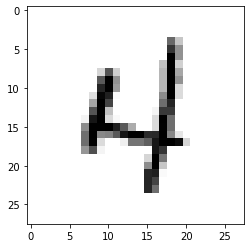

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

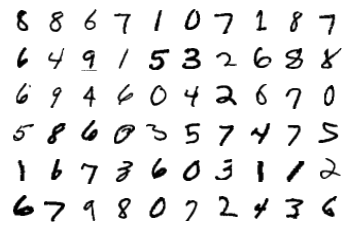

In [11]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Train and Test Definitions

In [12]:
from tqdm import tqdm

train_losses = []
train_accs = []
test_losses = []
test_accs= []

def train(model, device, train_loader, optimizer, epoch):
    correct_preds = 0
    processed = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Porting the data and targets in to the GPU
        data, target = data.to(device), target.to(device)

        # setting all the gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Loss calculation 
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Back propogation
        loss.backward()

        # Updating the weights with calculated gradients
        optimizer.step()

        # Calculating the correct number of predictions
        preds = output.argmax(dim=1, keepdim=True)
        correct_preds += preds.eq(target.view_as(preds)).sum().item()
        processed += len(data)
        
        # Logging the results using Pbar
        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct_preds/processed:0.2f}')

        # Appending the training accuracies to the train_accs[]
        train_accs.append(100*correct_preds/processed)
        


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Porting the data and targets in to the GPU
            data, target = data.to(device), target.to(device)

            # Predict 
            output = model(data)

            # Test loss calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accs.append(100. * correct / len(test_loader.dataset))

## Training and Test loops

In [13]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 15
for epoch in range(0, num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-09633435e7fb>:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch=0 Loss=2.3043930530548096 Batch_id=468 Accuracy=11.24: 100%|██████████| 469/469 [00:05<00:00, 91.79it/s] 



Test set: Average loss: 2.3007, Accuracy: 1135/10000 (11.35%)



Epoch=1 Loss=0.15917685627937317 Batch_id=468 Accuracy=43.48: 100%|██████████| 469/469 [00:04<00:00, 105.60it/s]



Test set: Average loss: 0.1458, Accuracy: 9569/10000 (95.69%)



Epoch=2 Loss=0.046230245381593704 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:04<00:00, 104.77it/s]



Test set: Average loss: 0.0656, Accuracy: 9801/10000 (98.01%)



Epoch=3 Loss=0.0724775642156601 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:04<00:00, 105.84it/s]



Test set: Average loss: 0.0546, Accuracy: 9830/10000 (98.30%)



Epoch=4 Loss=0.1606682389974594 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:04<00:00, 107.20it/s]



Test set: Average loss: 0.0495, Accuracy: 9834/10000 (98.34%)



Epoch=5 Loss=0.06565891206264496 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:04<00:00, 104.82it/s]



Test set: Average loss: 0.0405, Accuracy: 9864/10000 (98.64%)



Epoch=6 Loss=0.04325246438384056 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:04<00:00, 105.60it/s]



Test set: Average loss: 0.0439, Accuracy: 9859/10000 (98.59%)



Epoch=7 Loss=0.01060843002051115 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:04<00:00, 103.45it/s]



Test set: Average loss: 0.0456, Accuracy: 9850/10000 (98.50%)



Epoch=8 Loss=0.1263047605752945 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:04<00:00, 104.28it/s]



Test set: Average loss: 0.0360, Accuracy: 9884/10000 (98.84%)



Epoch=9 Loss=0.029177924618124962 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:04<00:00, 106.00it/s]



Test set: Average loss: 0.0344, Accuracy: 9881/10000 (98.81%)



Epoch=10 Loss=0.04264659807085991 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:04<00:00, 104.22it/s]



Test set: Average loss: 0.0345, Accuracy: 9885/10000 (98.85%)



Epoch=11 Loss=0.04414284601807594 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:04<00:00, 103.93it/s]



Test set: Average loss: 0.0337, Accuracy: 9894/10000 (98.94%)



Epoch=12 Loss=0.05678737163543701 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:04<00:00, 104.67it/s]



Test set: Average loss: 0.0358, Accuracy: 9878/10000 (98.78%)



Epoch=13 Loss=0.0888642743229866 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:04<00:00, 104.65it/s]



Test set: Average loss: 0.0354, Accuracy: 9881/10000 (98.81%)



Epoch=14 Loss=0.05700196325778961 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:04<00:00, 105.29it/s]



Test set: Average loss: 0.0300, Accuracy: 9896/10000 (98.96%)



In [14]:
import numpy 
train_losses = [i.cpu().detach().numpy() for i in train_losses]

In [15]:

test_losses = [i for i in test_losses]
train_accs = [i for i in train_accs]
test_accs = [i for i in test_accs]


## Training and testing Curves

Text(0.5, 1.0, 'Test Accuracy')

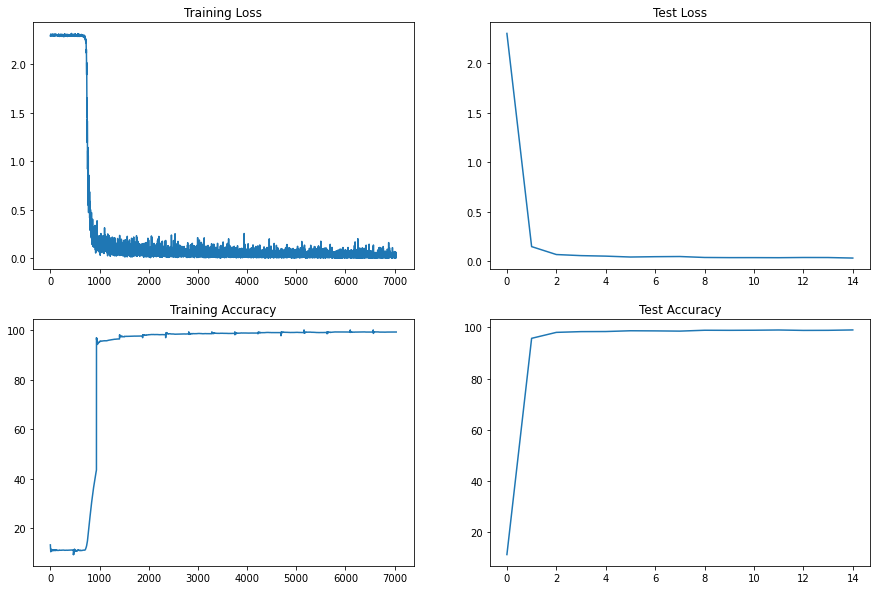

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")